In [692]:
# Initial Imports 
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
pd.set_option("display.max_columns", None)

In [693]:
df_client_data = pd.read_csv('../HET/Data/client_data.csv')
df_client_membership = pd.read_csv('../HET/Data/client_membership.csv')
df_benchmark = pd.read_csv('../HET/Data/benchmark_data.csv')

/var/folders/h4/bmfyh9q95ws8cxksqm1z9m4c0000gn/T/ipykernel_21049/1195080869.py:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_client_data = pd.read_csv('../HET/Data/client_data.csv')
/var/folders/h4/bmfyh9q95ws8cxksqm1z9m4c0000gn/T/ipykernel_21049/1195080869.py:3: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_benchmark = pd.read_csv('../HET/Data/benchmark_data.csv')


In [695]:
df_client_data.columns

table_df = pd.DataFrame({'Metric': [df_client_data.columns]})


# Paid PMPM 
Paid per Member per Month - is a primary metric used to evaluate performance.

Calculated as = (Total_Paid / Member_Months)

We'll train an ML regressor model to predict PMPM and,  
use feature importance to gain insight on which features most contribute to PMPM


## Initial Data Manipulation 

In [696]:
# Convert to to numerics, excluding member key and CCS_Dx_levels

object_cols = df_client_data.columns[df_client_data.dtypes.eq('object')]
object_cols
object_cols = object_cols.drop(['dw_mbr_key', 'Primary_CCS_Dx_Level_1', 'Primary_CCS_Dx_Level_2'])

df_client_data[object_cols] = df_client_data[object_cols].apply(pd.to_numeric, errors='coerce')


In [697]:
# Sum Total_Paid for all claims by member 
totals = df_client_data.groupby('dw_mbr_key', as_index=False)['Total_Paid'].sum()

# Merge Totals to client_membership
df = pd.merge(df_client_membership, totals, on='dw_mbr_key')
df.head()

,dw_mbr_key,gender,age,zip_cd,relationship,enrollment_month,MSA,state,area_id,risk_score,sdoh_percentile,urban_percentile,hypertension_ind,depression_ind,hyperlipidemia_ind,cad_ind,diabetes_ind,alcohol_ind,sud_ind,copd_ind,psychotic_ind,hypothyroidism_ind,anxiety_ind,cancer_ind,pregnancy_ind,annual_wellness_visit,Total_Paid
0,"5,960,230,933",F,54,98503,Subscriber,12,"Olympia, WA",WA,"5,301",0.58,0.65,0.82,0,0,0,0,0,0,0,0,0,0,0,0,0,0,295.39
1,"1,400,067,594",M,51,75474,Subscriber,12,"Dallas-Fort Worth-Arlington, TX",TX,"4,807",0.78,0.91,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,1,202.38
2,"165,580,000,688",F,39,75214,Subscriber,12,"Dallas-Fort Worth-Arlington, TX",TX,"4,807",5.65,0.69,0.82,1,1,1,0,1,0,0,0,0,0,1,1,0,0,4239.04
3,"1,450,054,588",F,55,30024,Spouse,12,"Atlanta-Sandy Springs-Marietta, GA",GA,"1,303",0.41,0.41,0.82,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00
4,"211,030,034,623",M,10,61704,Dependent,12,"Bloomington-Normal, IL",IL,"1,707",0.21,0.35,0.8,0,0,0,0,0,0,0,0,0,0,0,0,0,1,184.53


In [698]:
# Dropping zip_cd, relationship, MSA, state
df = df.drop(['zip_cd', 'relationship', 'MSA', 'state'], axis=1)

# Cast sdoh_percentile, urban_percentile as numerics 
object_cols = df.columns[df.dtypes.eq('object')]
object_cols
object_cols = object_cols.drop(['dw_mbr_key', 'gender', 'area_id'])

df[object_cols] = df[object_cols].apply(pd.to_numeric, errors='coerce')

In [699]:
# Ordinal Encoding Gender and Area ID 
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
df[['gender', 'area_id']] = encoder.fit_transform(df[['gender', 'area_id']])

In [700]:
# Search for nuls in dataframe 
print(df.shape)

# Number of Missing Values in each column 
missing_val_count = (df.isnull().sum())
print(missing_val_count[missing_val_count > 0])

(89966, 23)
sdoh_percentile     1218
urban_percentile    1218
dtype: int64


In [701]:
# Null values account for approximately < 1% of our data.
# We can drop them from our dataframe 

df = df.dropna()

## PMPM Evaluation 

In [702]:
# Calculate PMPM and append to dataframe 
df['PMPM'] = df['Total_Paid'] / df['enrollment_month']

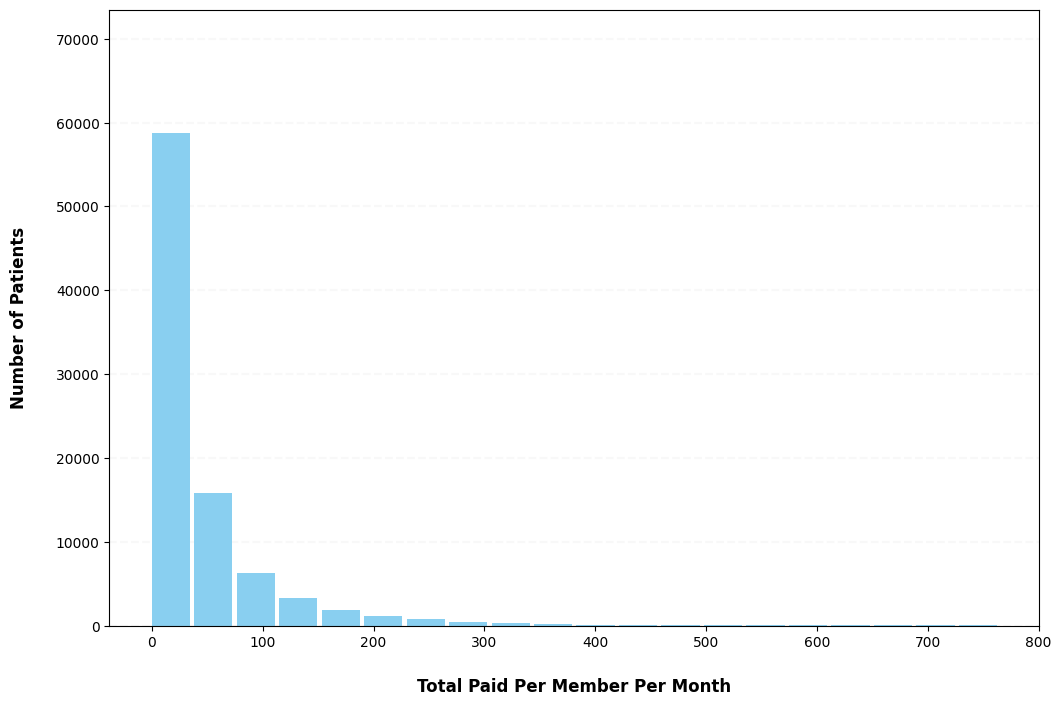

In [703]:
ax = df.hist(column='PMPM', bins=20, grid=False, figsize=(12,8), color='#89cff0', zorder=2, rwidth=0.9)

ax = ax[0]
for x in ax:
    
    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("")

    # Set x-axis label
    x.set_xlabel("Total Paid Per Member Per Month", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    x.set_ylabel("Number of Patients", labelpad=20, weight='bold', size=12)

## ML Modeling


### Data Split 

In [704]:
# Get X y variables 
X = df.drop(['enrollment_month','Total_Paid', 'PMPM'], axis=1)
# X = df.drop(['enrollment_month','Total_Paid', 'PMPM', 'risk_score'], axis=1)
y = df.PMPM

# Data split 
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=.7, test_size=.3, random_state=0)

# Drop unique member ID for ML modeling 
X_train_ml = X_train.drop(['dw_mbr_key'], axis=1)
X_val_ml = X_val.drop(['dw_mbr_key'], axis=1)

### Training Random Forest Regressor

In [705]:
from sklearn.ensemble import RandomForestRegressor

# Define models 
model_1 = RandomForestRegressor(n_estimators=50, random_state=0)
model_2 = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=0)
model_3 = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=0)

rf_models = [model_1, model_2, model_3]

In [706]:
# Evaluating models Mean Absolute Error 

from sklearn.metrics import mean_absolute_error

# Function for comparing models 
def score_model(model, X_t=X_train_ml, X_v=X_val_ml, y_t=y_train, y_v=y_val):
    model.fit(X_t, y_t)
    preds = model.predict(X_v)
    return mean_absolute_error(y_v, preds)

for i in range(len(rf_models)):
    mae = score_model(rf_models[i])
    print("Model %d MAE: %d" % (i+1, mae))

Model 1 MAE: 27
Model 2 MAE: 27
Model 3 MAE: 26


### Use respective RF model to analyze feature importance 

In [707]:
predictions = model_3.predict(X_val_ml)

<BarContainer object of 20 artists>

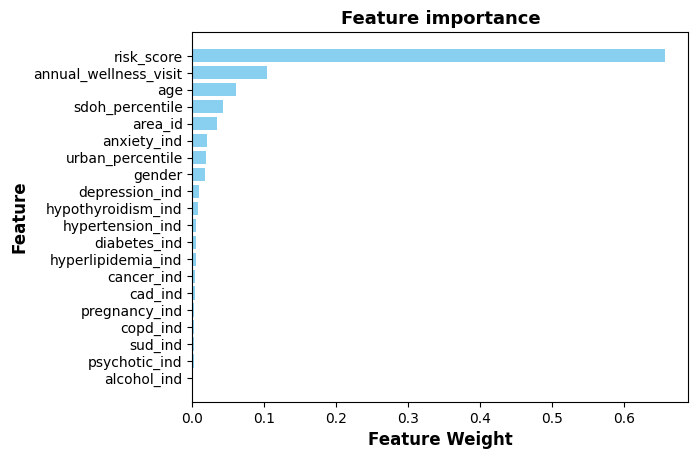

In [708]:
# Get Feature importance 
importances = model_3.feature_importances_
features = X_val_ml.columns


unsorted_list = [(importance, feature) for feature, importance in 
                  zip(features, importances)]
sorted_list = sorted(unsorted_list)

features_sorted = []
importance_sorted = []

for i in sorted_list:
    features_sorted += [i[1]]
    importance_sorted += [i[0]]

# Plot Feature Importance 
plt.title("Feature importance", fontsize=13, fontweight='bold')
plt.xlabel("Feature Weight", fontsize=12, fontweight='bold')
plt.ylabel("Feature", fontsize=12, fontweight='bold')

plt.barh(features_sorted,importance_sorted, color="#89cff0")

# plt.savefig('importance_barh.png', dpi=100)

# Annual Wellness Visit 
From the RF Regressor model, we can see that Age and Annual_Wellness_Visits are have the highest contribution to a high PMPM. 

Inpatient visits are typically more constly. 

We'll now look at the different reasons patients went for an inpatient treatment 



In [709]:
# Get Comparison of Total Price Paid 
visits = pd.read_csv('./Data/visits.csv')

# Get all visits
outpatient_visits = visits.loc[visits.Paid_Outpatient > 0]
inpatient_visits = visits.loc[visits.Paid_Inpatient > 0]
profesional_visits = visits.loc[visits.Paid_Professional > 0]

outpatient_counts =  len(outpatient_visits)
inpatient_counts = len(inpatient_visits)
professional_counts = len(profesional_visits)


counts = [outpatient_counts, inpatient_counts, professional_counts]

outpatient_total = outpatient_visits['Paid_Outpatient'].sum()
professional_total = profesional_visits['Paid_Outpatient'].sum()
inpatient_total = inpatient_visits['Paid_Outpatient'].sum()

totals = [outpatient_total, inpatient_total, professional_total]

avg_per_visit_type = [outpatient_total/outpatient_counts,
                        inpatient_total/inpatient_counts,
                        professional_total/professional_counts]

visits_df = pd.DataFrame({'Visit Type': ['Outpatient', 'Inpatient', 'Professional'],
                         'Number of Visits': counts,
                         'Average Pay By Visit Type': avg_per_visit_type})

visits_df['Average Pay By Visit Type'] = visits_df['Average Pay By Visit Type'].round()
visits_df


,Visit Type,Number of Visits,Average Pay By Visit Type
0,Outpatient,40218,2721.0
1,Inpatient,3499,2254.0
2,Professional,215795,448.0


In [710]:
inpatient_df = pd.read_csv('../HET/Data/inpatient.csv')
inpatient_df = inpatient_df.loc[inpatient_df.Paid_Inpatient > 0]


/var/folders/h4/bmfyh9q95ws8cxksqm1z9m4c0000gn/T/ipykernel_21049/637889279.py:1: DtypeWarning: Columns (0,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  inpatient_df = pd.read_csv('../HET/Data/inpatient.csv')


In [711]:
# Total Paid_Inpatient per Primary_CCS_Dx_Level_1
inpatient_totals = inpatient_df.groupby('Primary_CCS_Dx_Level_1', as_index=False)['Paid_Inpatient'].sum()


# Total Inpatient Visits per Primary_CCS_Dx_Level_1
visits = inpatient_df.Primary_CCS_Dx_Level_1.value_counts().rename_axis('Primary_CCS_Dx_Level_1').reset_index(name='counts')

inpatient_table = pd.merge(inpatient_totals, visits, on='Primary_CCS_Dx_Level_1')

# Append Visits / 100 
# Calculated as (Admissions / Members) * 1000

member_count = df_client_membership.dw_mbr_key.unique().size

inpatient_table['Admissions / 1000'] = (inpatient_table['counts'] / member_count) * 1000

<AxesSubplot: title={'center': 'Total Paid Per Primary_CCS_Dx_Level_1'}, ylabel='Primary_CCS_Dx_Level_1'>

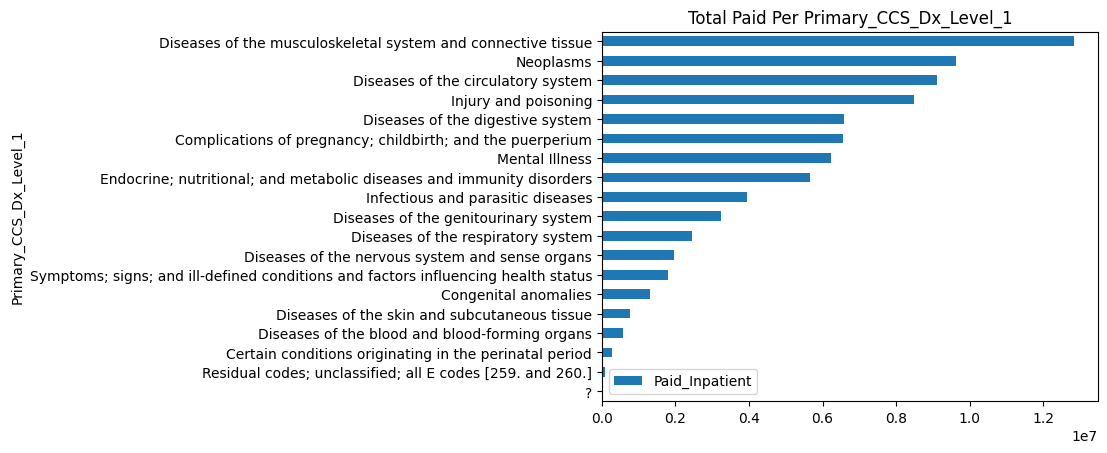

In [712]:
# Plot Total Inpatient Paid per Primary_CCS_Dx_Level_1
paid_plot_data = inpatient_table[['Primary_CCS_Dx_Level_1', 'Paid_Inpatient']]
paid_plot_data = paid_plot_data.sort_values(by=['Paid_Inpatient'])

paid_plot_data.plot.barh(x='Primary_CCS_Dx_Level_1', title='Total Paid Per Primary_CCS_Dx_Level_1')

<AxesSubplot: title={'center': 'Number of IP Admissions per 1000 Members'}, ylabel='Primary_CCS_Dx_Level_1'>

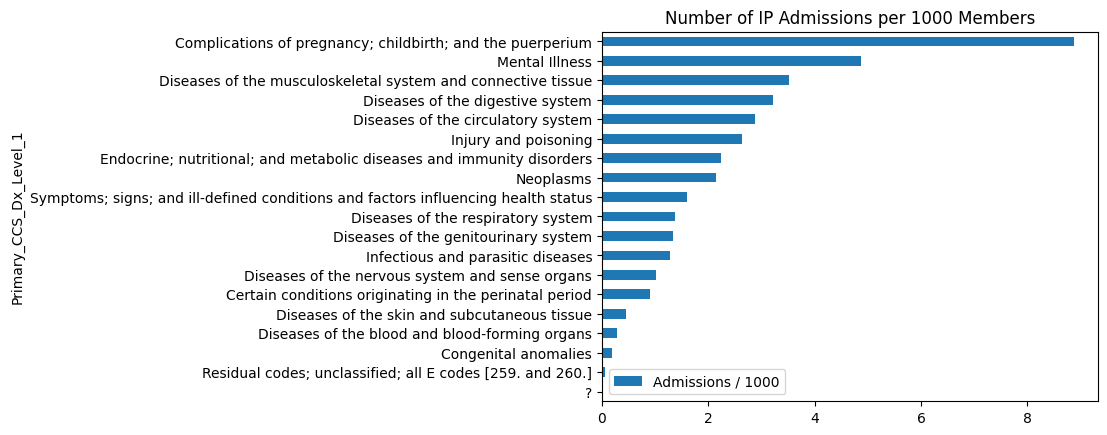

In [713]:
# Plot Total Inpatient Paid per Primary_CCS_Dx_Level_1
admissions_plot_data = inpatient_table[['Primary_CCS_Dx_Level_1', 'Admissions / 1000']]
admissions_plot_data = admissions_plot_data.sort_values(by=['Admissions / 1000'])

admissions_plot_data.plot.barh(x='Primary_CCS_Dx_Level_1', title='Number of IP Admissions per 1000 Members')

In [714]:
pd.set_option('display.max_colwidth', None)
paid_plot_data.tail(5).sort_values(['Paid_Inpatient'])

,Primary_CCS_Dx_Level_1,Paid_Inpatient
6,Diseases of the digestive system,6587604.07
14,Injury and poisoning,8497860.57
5,Diseases of the circulatory system,9105347.03
16,Neoplasms,9641234.22
8,Diseases of the musculoskeletal system and connective tissue,12845607.20


In [715]:
admissions_plot_data.tail(5).sort_values(['Admissions / 1000'])

,Primary_CCS_Dx_Level_1,Admissions / 1000
5,Diseases of the circulatory system,2.878865
6,Diseases of the digestive system,3.223440
8,Diseases of the musculoskeletal system and connective tissue,3.512438
15,Mental Illness,4.868506
2,Complications of pregnancy; childbirth; and the puerperium,8.881133
